# 0.0. Import 

In [301]:
import math
import pandas as pd
#import inflection 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.linear_model import LinearRegression, Lasso

from scipy import stats as ss
from boruta import BorutaPy
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import linear_model  as lm


from matplotlib import pyplot as plt
from IPython.core.display import HTML

In [314]:
import math
import pandas as pd
import inflection 
import numpy as np
import seaborn as sns
#import xgboost as xgb
import random
import pickle
import json

from scipy import stats as ss
from boruta import BorutaPy
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

from matplotlib import pyplot as plt
from IPython.core.display import HTML

## 0.1 Helper Func


In [96]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def barplot_percentage_without_hue(feature, data, x_label = None, y_label = None, title = None):

    aux = pd.DataFrame( data[feature].value_counts(normalize = True).reset_index() )
    aux.columns = [feature , 'values']
    ax = sns.barplot(x=feature ,y='values', data=aux)
    aux = data[feature].value_counts(normalize = True)
    i = 0
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * aux[i] )
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy()
            plt.text(x+width/2,
             y+height*1.01,
             str(percentage)+'',
             ha='center',
             weight='bold')
            i = i + 1
    #plt.figure(figsize=[12,8])
    plt.xlabel(x_label)
    plt.ylabel( y_label)
    plt.title( title, fontsize=18)
    plt.show()

def barplot_percentage_with_hue( x, hue, data, x_label=None, y_label=None, title = None, size = 8):
    
    new_df = data.groupby(x)[hue].value_counts( normalize=True)
    new_df = new_df.mul(100).rename( 'Percent').reset_index()
    g = sns.catplot( x=x, y='Percent', hue=hue, kind='bar', data=new_df, height = size , aspect = 1.2 )
    g.ax.set_ylim(0, 100)
    
    #g.fig(figsize=(20, 10))
    for p in g.ax.patches:
        txt = str(p.get_height().round(1)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)
        
    plt.xlabel(x_label)
    plt.ylabel( y_label)
    plt.title( title, fontsize=18)

In [46]:
jupyter_settings()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data


In [7]:
df_bank_raw = pd.read_csv ('churn.csv', low_memory=False)

# 1.0 Descriçao de Dados

In [8]:
df1 = df_bank_raw.copy()

In [9]:
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 1.2. Data Dimensions

In [10]:
print('Number of Rows: {}' .format(df1.shape[0]))
print('Number of Columns: {}' .format(df1.shape[1]))

Number of Rows: 10000
Number of Columns: 14


## 1.3. Data Type

In [11]:
df1.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 1.4 Check NA

In [12]:
df1.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## 1.5 Descriptive Statiscal

In [13]:
#numerical
num_attribute = df1.select_dtypes ( include=['int64','float64'])

#categorical
cat_attribute = df1.select_dtypes (exclude=['int64', 'float64'])

## 1.7.1 Numerical Statiscal

In [21]:
num_attribute.apply( lambda x: x.unique().shape[0])

RowNumber          10000
CustomerId         10000
CreditScore          460
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [22]:
#Central Tendency - mean, median 
ct1 = pd.DataFrame(num_attribute.apply(np.mean)).T
ct2 = pd.DataFrame(num_attribute.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attribute.apply(np.std)).T
d2 = pd.DataFrame(num_attribute.apply(min)).T
d3 = pd.DataFrame(num_attribute.apply(max)).T
d4 = pd.DataFrame(num_attribute.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attribute.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attribute.apply(lambda x: x.kurtosis())).T
                  
#concat
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes' ,'min' ,'max' ,'range' ,'mean' ,'median' ,'std' ,'skew' ,'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,RowNumber,1.000,10000.000,9999.000,5000.500,5000.500,2886.751,0.000,-1.200
1,CustomerId,15565701.000,15815690.000,249989.000,15690940.569,15690738.000,71932.589,0.001,-1.196
2,CreditScore,350.000,850.000,500.000,650.529,652.000,96.648,-0.072,-0.426
3,Age,18.000,92.000,74.000,38.922,37.000,10.487,1.011,1.395
4,Tenure,0.000,10.000,10.000,5.013,5.000,2.892,0.011,-1.165
5,Balance,0.000,250898.090,250898.090,76485.889,97198.540,62394.285,-0.141,-1.489
6,NumOfProducts,1.000,4.000,3.000,1.530,1.000,0.582,0.746,0.583
7,HasCrCard,0.000,1.000,1.000,0.706,1.000,0.456,-0.902,-1.187
8,IsActiveMember,0.000,1.000,1.000,0.515,1.000,0.500,-0.060,-1.997
9,EstimatedSalary,11.580,199992.480,199980.900,100090.240,100193.915,57507.617,0.002,-1.182


Churn Ratio: 20,4%

51,5% of the members are active

70,6% of the members has credit card

## 1.7.2 Categorical Statiscal

In [66]:
cat_attribute.describe().T

,count,unique,top,freq
Surname,10000,2932,Smith,32
Geography,10000,3,France,5014
Gender,10000,2,Male,5457


### 1.7.2.1 Geography

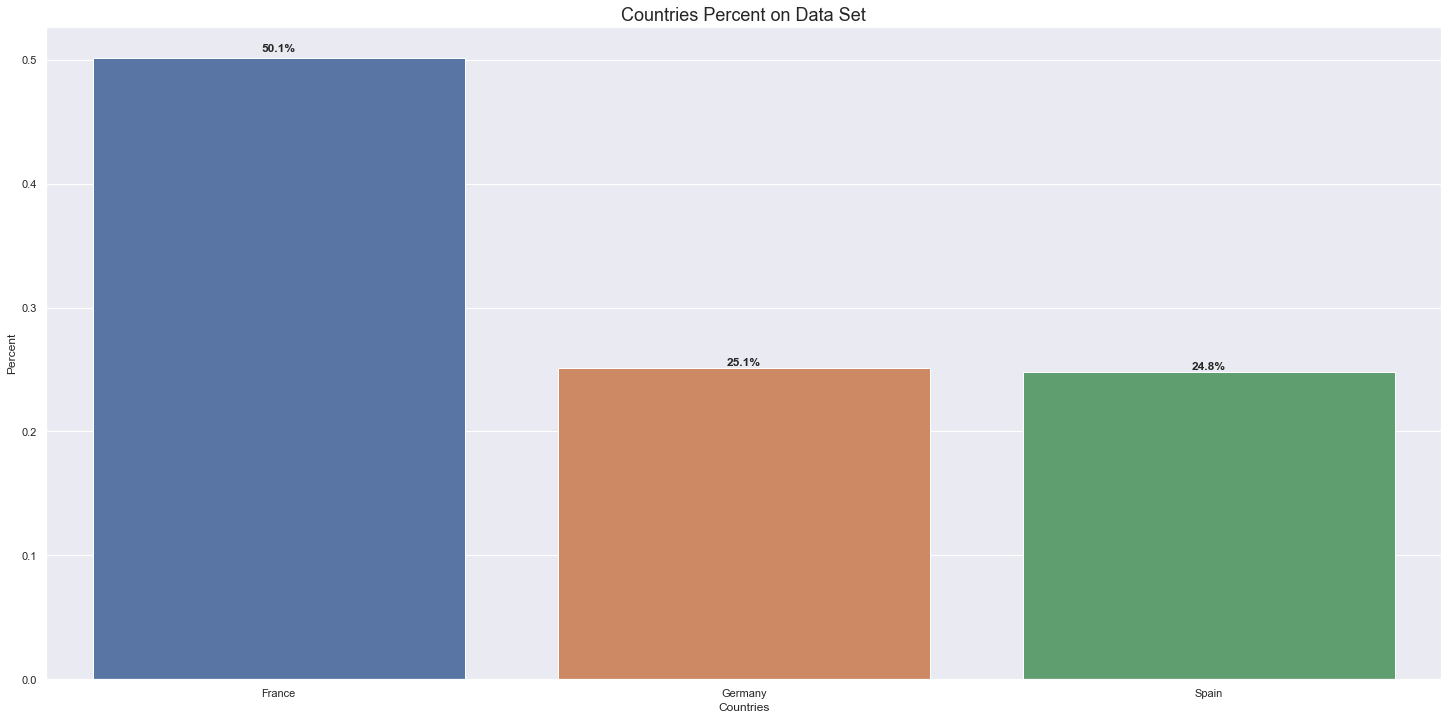

In [74]:
barplot_percentage_without_hue(feature='Geography', data=df1, x_label='Countries' , y_label='Percent' , title='Countries Percent on Data Set') 

### 1.7.2.2 Gender

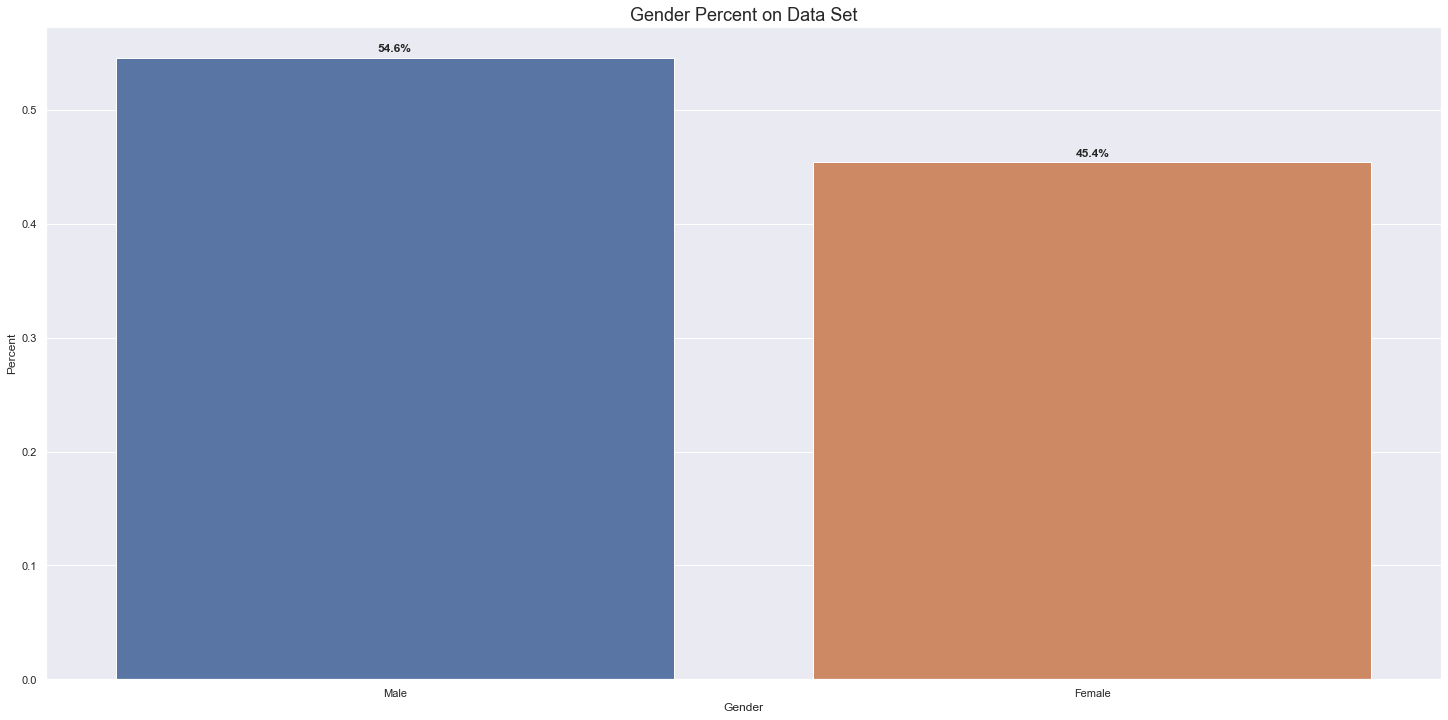

In [76]:
barplot_percentage_without_hue(feature='Gender', data=df1, x_label='Gender' , y_label='Percent' , title='Gender Percent on Data Set') 

# 2.0 Data Engineering


In [213]:
df2 = df1.copy()

## 2.1 Creating Hypothesis


1.0 **Homens** dão mais Churn

2.0 Franceses dao mais Churn

3.0 Membros Nao ativos temdem ao Churn

4.0 Membros que nao tem HasCrCard tendem ao Churn

5.0 Membros com EstimatedSalary menor que 57.000. tendem ao Churn

6.0 Membros com menor CreditScore tendem ao Churn

7.0 Membros com Balance 0 tendem ao Churn

8.0 Jovens Tendem ao Churn

## 2.2. Feature Engineering

In [214]:
# calculates average salary
MeanSalary = np.mean( df2['EstimatedSalary'].values )
df2['MeanSalary'] = MeanSalary

#credit_level
# 350 - 579 -> poor
#580-669 -> fair
# 670 - 739 -> Good
# 740 - 799 -> very good
# 800 - 850 - great
df2['CreditLevel'] = df2['CreditScore'].apply( lambda x: 'poor' if x <= 579 else 'fair' if (x > 579) & (x < 670)
                                          else 'good' if (x > 669 ) & ( x < 740) else 'very_good' if (x > 739) & (x < 800) else 'great' ) 


In [215]:
# calculate how much the company earned with the client
df2['GrossRevenue'] = df2['EstimatedSalary'].apply( lambda x: x*0.15 if x <= MeanSalary else x*0.20)
df2['GrossRevenue'] = df2['GrossRevenue']*df2['Tenure']

## 3.0. Filtragem de Variaveis


In [216]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

## 3.2. Selecao das Colunas


In [217]:
#removing unnecessary columns
df3 = df3.drop(['RowNumber', 'Surname' ] , axis=1)

In [218]:
df3.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,MeanSalary,CreditLevel,GrossRevenue
0,15634602,619,France,Female,42,2,0.000,1,1,1,101348.880,1,100090.240,fair,40539.552
1,15647311,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0,100090.240,fair,22508.516
2,15619304,502,France,Female,42,8,159660.800,3,1,0,113931.570,1,100090.240,poor,182290.512
3,15701354,699,France,Female,39,1,0.000,2,0,0,93826.630,0,100090.240,good,14073.995
4,15737888,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0,100090.240,great,23725.230


# 4.0 Analise Exploratoria do Dados


In [219]:
df4 = df3.copy()

## 4.1 - Analise Univariada


### 4.1.1 - Numerical Variable

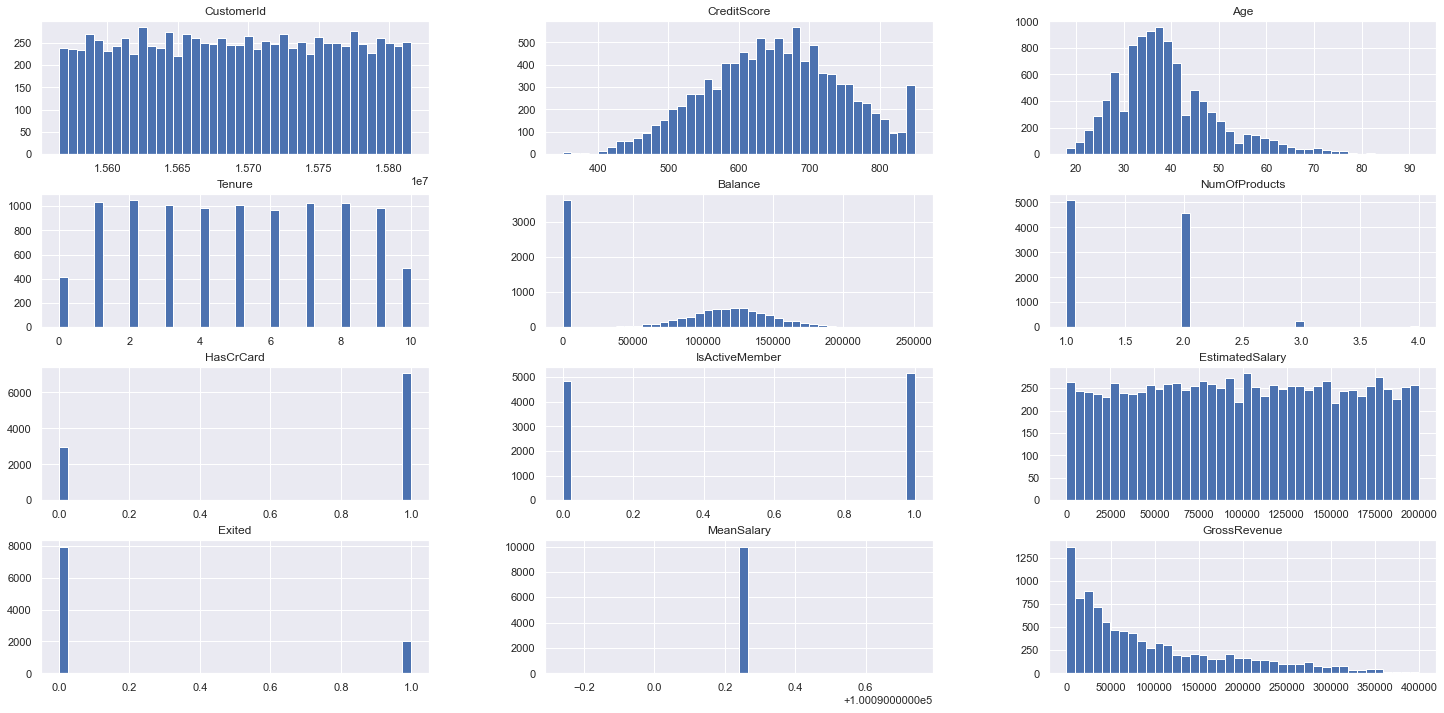

In [220]:
df4.hist(bins = 40); 

## 4.1.2 - Categorical Variable

## 4.2 Bivariate Analysis


1.0 **Homens** dão mais Churn
False - Mulheres dao mais Churn

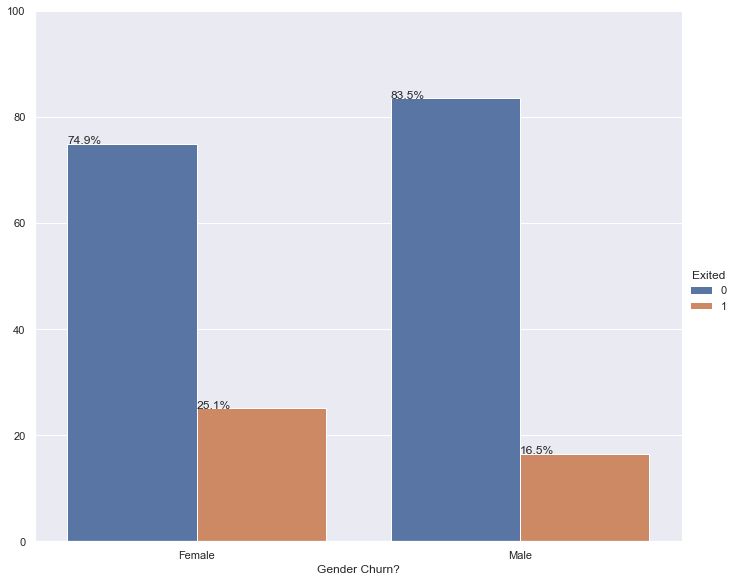

In [221]:
barplot_percentage_with_hue( x='Gender', hue='Exited', data=df4 , x_label='Gender Churn?'); 

2.0 Franceses dao mais Churn
Falso, Alemaes dao mais Churn

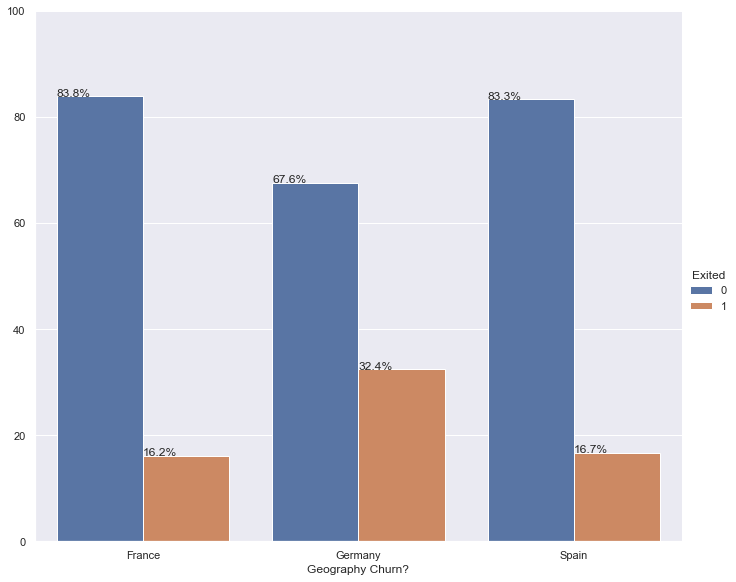

In [222]:
barplot_percentage_with_hue( x='Geography', hue='Exited', data=df4 , x_label='Geography Churn?'); 

3.0 Membros Nao ativos temdem ao Churn 

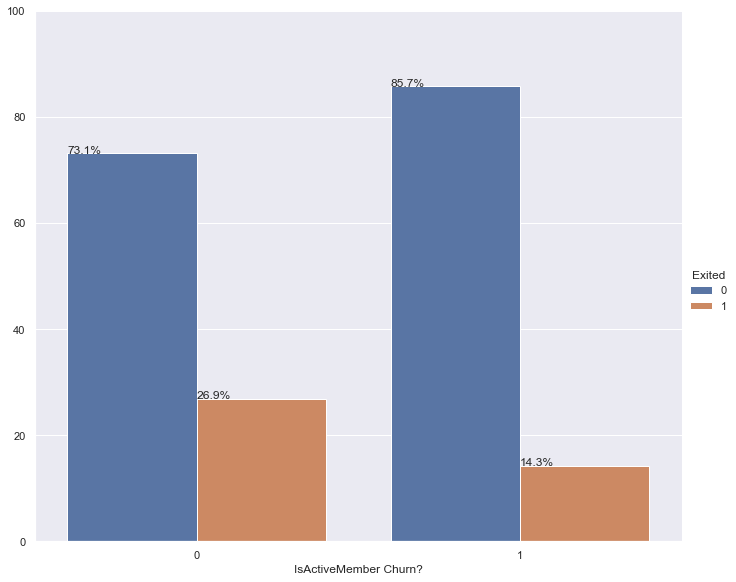

In [223]:
barplot_percentage_with_hue( x='IsActiveMember', hue='Exited', data=df4 , x_label='IsActiveMember Churn?'); 

4.0 Membros que nao tem HasCrCard tendem ao Churn

Sim, porém é bem pequena a diferença

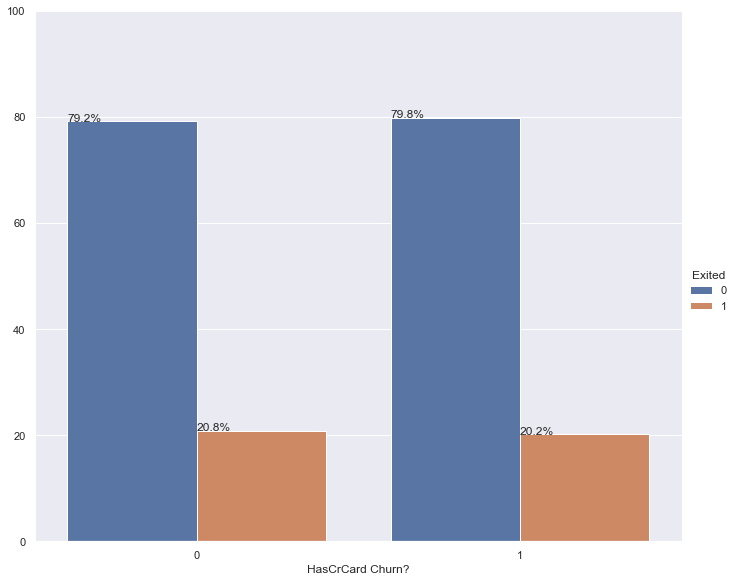

In [224]:
barplot_percentage_with_hue( x='HasCrCard', hue='Exited', data=df4 , x_label='HasCrCard Churn?'); 

5.0 Membros com EstimatedSalary menor que a Média. tendem ao Churn

True

In [225]:
aux1 = df4[['MeanSalary','EstimatedSalary','Exited']]
aux1['Under']= aux1.apply(lambda x: 1 if x['EstimatedSalary'] < x['MeanSalary'] else 0, axis=1)

<ipython-input-225-744b196782b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['Under']= aux1.apply(lambda x: 1 if x['EstimatedSalary'] < x['MeanSalary'] else 0, axis=1)


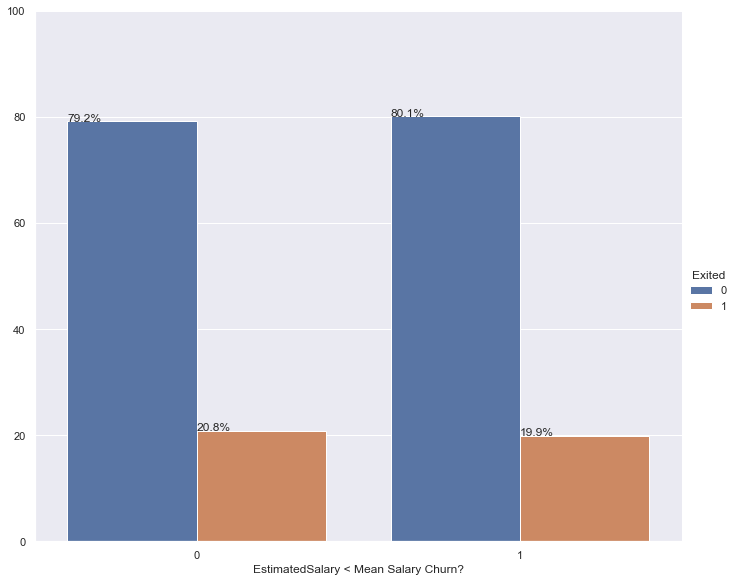

In [226]:
barplot_percentage_with_hue( x='Under', hue='Exited', data=aux1 , x_label='EstimatedSalary < Mean Salary Churn?'); 

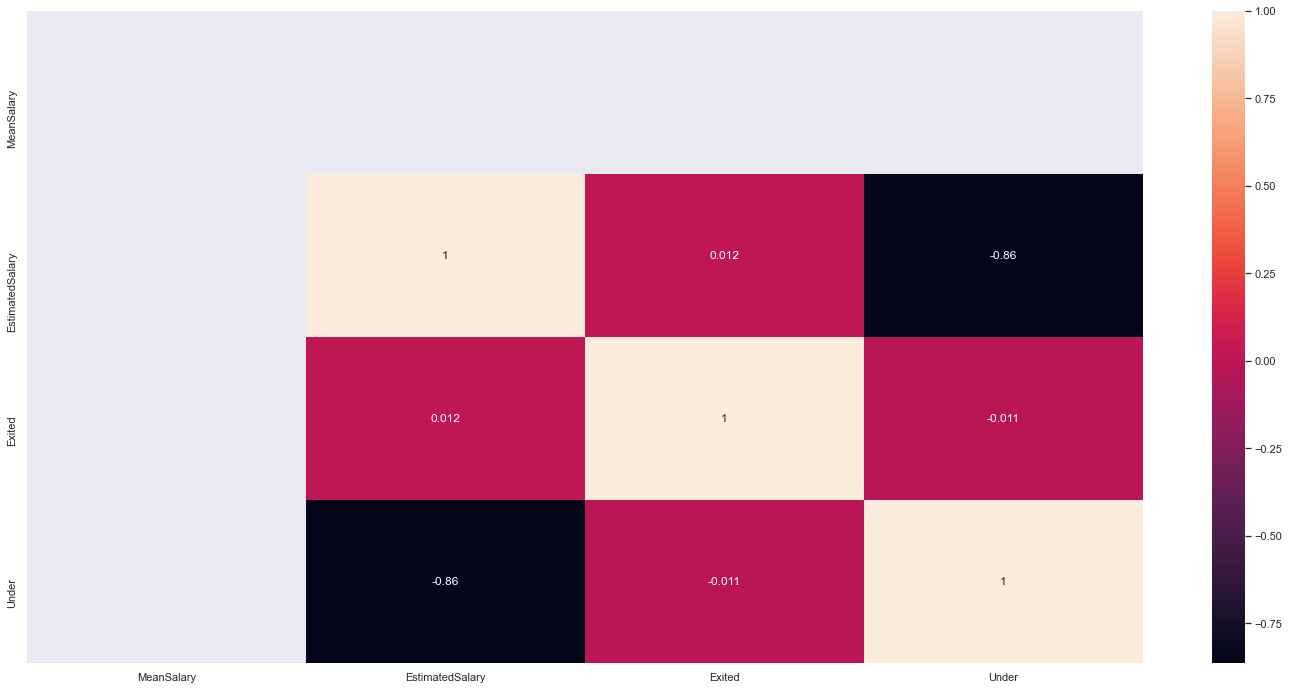

In [227]:
sns.heatmap(aux1.corr(method='pearson'), annot=True);

6.0 Membros com menor CreditScore tendem ao Churn

True

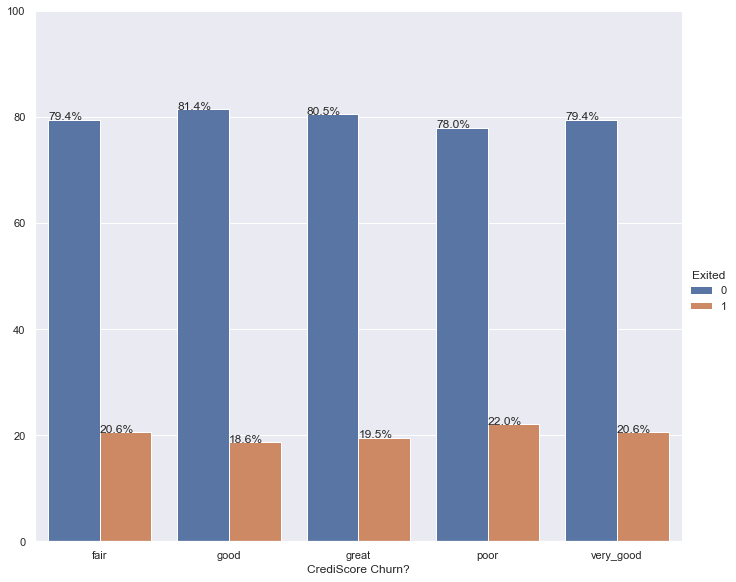

In [228]:
barplot_percentage_with_hue( x='CreditLevel', hue='Exited', data=df4 , x_label='CrediScore Churn?'); 

7.0 Membros com Balance 0 tendem ao Churn

FALSE

In [229]:
aux2 = df4[['Balance','Exited']]
aux1['Balance0']= aux2.apply(lambda x: 1 if x['Balance'] == 0 else 0, axis=1)

<ipython-input-229-4c19c9594786>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['Balance0']= aux2.apply(lambda x: 1 if x['Balance'] == 0 else 0, axis=1)


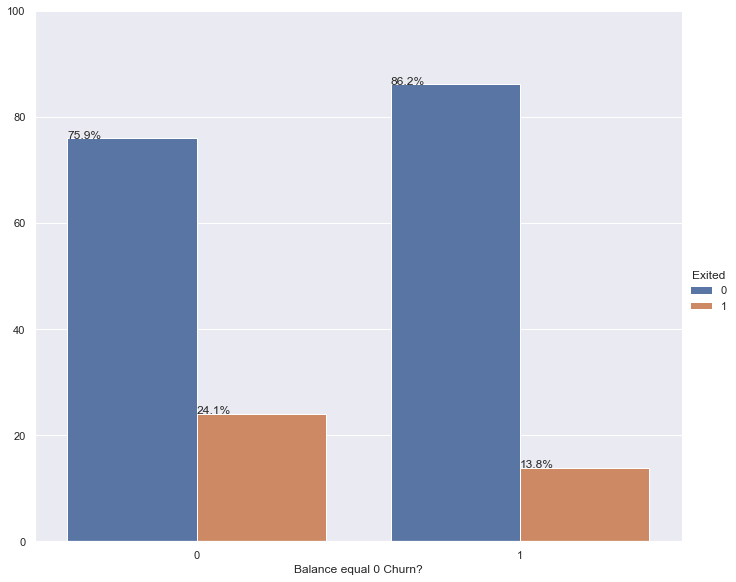

In [230]:
barplot_percentage_with_hue( x='Balance0', hue='Exited', data=aux1 , x_label='Balance equal 0 Churn?'); 

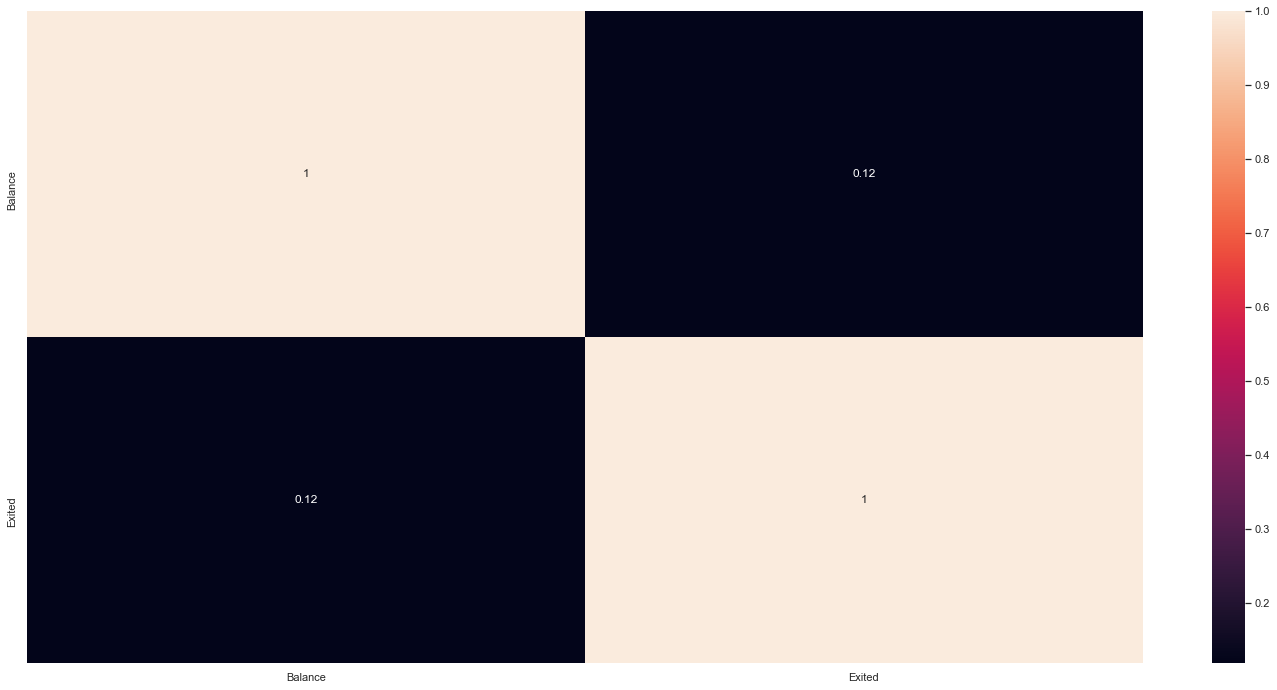

In [231]:
sns.heatmap(aux2.corr(method='pearson'), annot=True);

8.0 Jovens Tendem ao Churn

False

/Users/jefersonlima/.pyenv/versions/3.8.3/envs/HousePredict/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jefersonlima/.pyenv/versions/3.8.3/envs/HousePredict/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


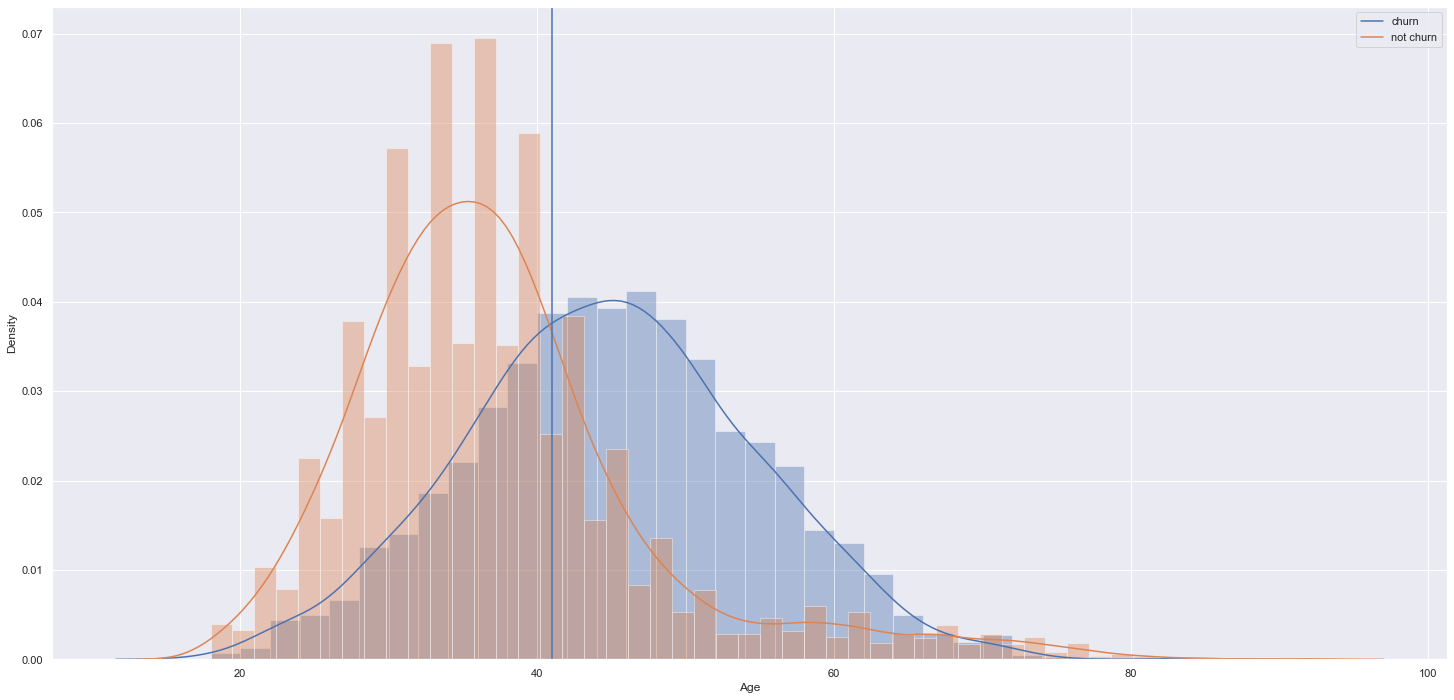

In [232]:
sns.distplot(df4[df4['Exited']==1]['Age'], label = 'churn' )
sns.distplot(df4[df4['Exited'] == 0 ]['Age'], label = 'Not Churn')
plt.axvline(41);
plt.legend( [ 'churn' , 'not churn']);

## 4.3 - Analise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot:>

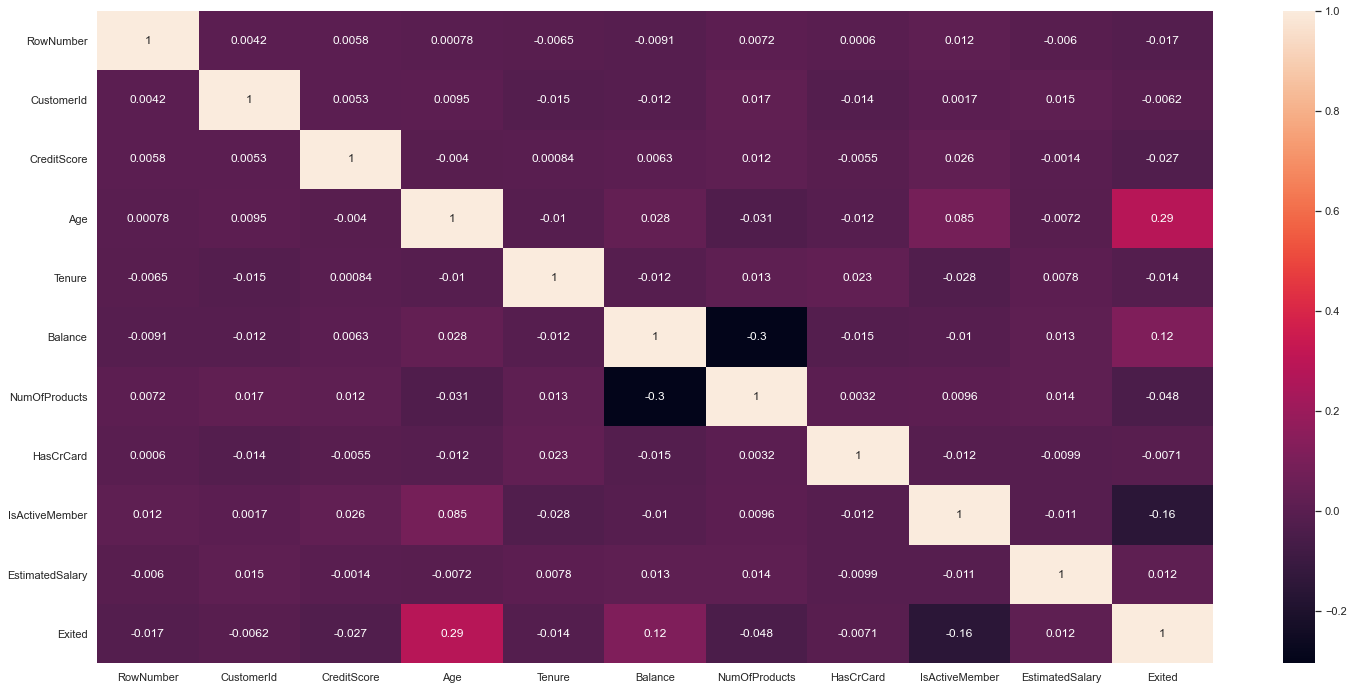

In [233]:
#numerical
num_attribute = df1.select_dtypes ( include=['int64','float64'])
correlation = num_attribute.corr(method = 'pearson')
sns.heatmap(correlation, annot=True)

## 5.0 Data Preparation


In [248]:
df5 = df4.copy()

In [249]:
df5.sample(10)

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,MeanSalary,CreditLevel,GrossRevenue
4560,15694518,624,Spain,Female,36,0,0.000,2,1,0,111605.900,0,100090.240,fair,0.000
7573,15674750,481,Spain,Female,37,8,0.000,2,1,0,44215.860,0,100090.240,poor,53059.032
6594,15808544,747,France,Female,40,3,0.000,1,0,0,57817.840,1,100090.240,very_good,26018.028
8928,15567855,623,France,Female,29,1,0.000,2,0,0,39382.060,0,100090.240,fair,5907.309
3946,15739168,511,France,Female,31,5,137411.290,1,0,1,161854.980,0,100090.240,poor,161854.980
4608,15614103,850,Germany,Male,42,8,119839.690,1,0,1,51016.020,1,100090.240,great,61219.224
3788,15707110,660,Germany,Male,28,2,170890.050,2,1,0,41758.900,0,100090.240,fair,12527.670
579,15658032,701,France,Male,39,2,0.000,2,1,1,82526.920,0,100090.240,good,24758.076
1411,15693904,685,Germany,Female,30,4,84958.600,2,0,1,194343.720,0,100090.240,good,155474.976
9021,15712199,655,Germany,Female,61,2,183997.700,2,1,1,161217.180,0,100090.240,fair,64486.872



## 5.1 Encoding

In [250]:
df5['CreditLevel'].unique() 

array(['fair', 'poor', 'good', 'great', 'very_good'], dtype=object)

In [251]:
#gender - label encoding 
gender_dict = { 'Male':1 , 'Female':2 }
df5['Gender'] = df5['Gender'].map( gender_dict ) 

#Geography - One Hot Encoding
df5 = pd.get_dummies(df5, prefix =['Geo'], columns=['Geography'])

#credit_level - ordinal encoding #
credit_dict = { 'poor': 1 , 'fair': 2 , 'good': 3 , 'very_good': 4, 'great' : 5 } 
df5['CreditLevel'] = df5['CreditLevel'].map( credit_dict )


In [252]:
df5.head()

,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,MeanSalary,CreditLevel,GrossRevenue,Geo_France,Geo_Germany,Geo_Spain
0,15634602,619,2,42,2,0.000,1,1,1,101348.880,1,100090.240,2,40539.552,1,0,0
1,15647311,608,2,41,1,83807.860,1,0,1,112542.580,0,100090.240,2,22508.516,0,0,1
2,15619304,502,2,42,8,159660.800,3,1,0,113931.570,1,100090.240,1,182290.512,1,0,0
3,15701354,699,2,39,1,0.000,2,0,0,93826.630,0,100090.240,3,14073.995,1,0,0
4,15737888,850,2,43,2,125510.820,1,1,1,79084.100,0,100090.240,5,23725.230,0,0,1


## 5.2 Rescaling


In [253]:
a = df5.select_dtypes(include =['int64', 'float'])
a.dtypes

CustomerId           int64
CreditScore          int64
Gender               int64
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
MeanSalary         float64
CreditLevel          int64
GrossRevenue       float64
dtype: object

/Users/jefersonlima/.pyenv/versions/3.8.3/envs/HousePredict/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/jefersonlima/.pyenv/versions/3.8.3/envs/HousePredict/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/jefersonlima/.pyenv/versions/3.8.3/envs/HousePredict/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing oth

<AxesSubplot:xlabel='GrossRevenue'>

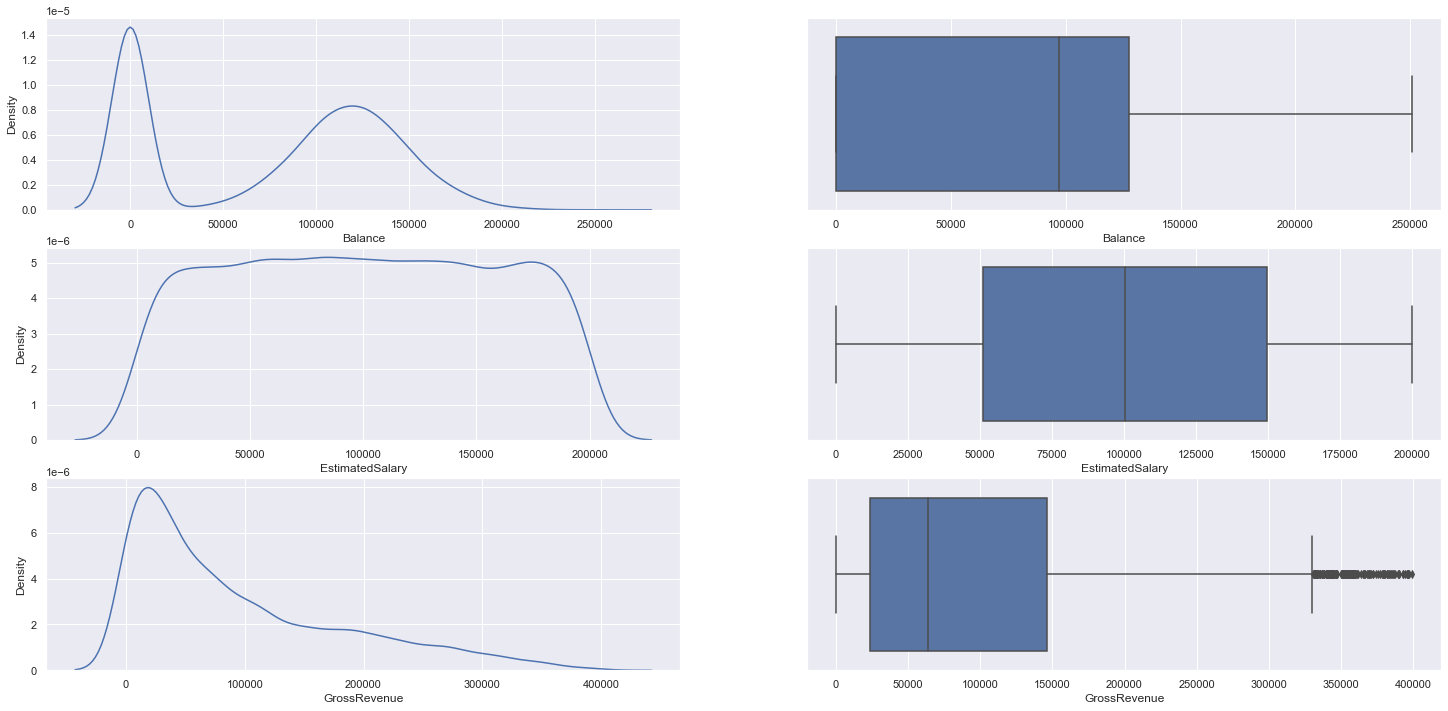

In [254]:
#boxplot

plt.subplot(3 ,2 ,1)
sns.kdeplot(a['Balance'])

plt.subplot(3 ,2 ,2)
sns.boxplot(a['Balance'])

plt.subplot(3, 2, 3)
sns.kdeplot(a['EstimatedSalary'])

plt.subplot(3, 2, 4)
sns.boxplot(a['EstimatedSalary'])

plt.subplot(3, 2, 5)
sns.kdeplot(a['GrossRevenue'])

plt.subplot(3, 2, 6)
sns.boxplot(a['GrossRevenue'])

<AxesSubplot:xlabel='GrossRevenue', ylabel='Density'>

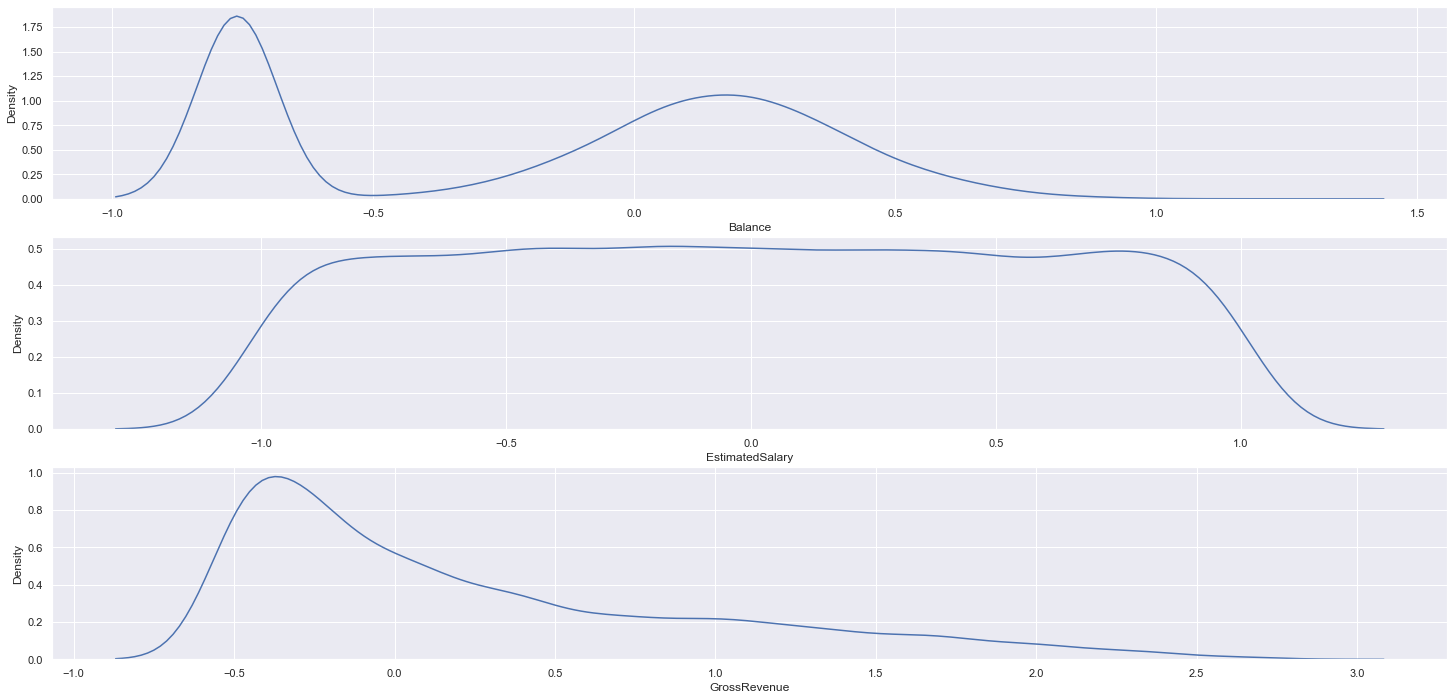

In [255]:
rs = RobustScaler()

#Balance
df5['Balance'] = rs.fit_transform(df5[['Balance']].values)

#EstimatedSalary
df5['EstimatedSalary'] = rs.fit_transform(df5[['EstimatedSalary']].values)

#GrossRevenue
df5['GrossRevenue'] = rs.fit_transform(df5[['GrossRevenue']].values)

#boxplot

plt.subplot(3 ,1 ,1)
sns.kdeplot(df5['Balance'])


plt.subplot(3, 1, 2)
sns.kdeplot(df5['EstimatedSalary'])

plt.subplot(3, 1, 3)
sns.kdeplot(df5['GrossRevenue'])

## 6.0 Feature Selection


In [279]:
df6= df5.copy()

## 6.1 Slipt DataFrame into Training and Test Dataset


In [282]:
#Features
x_train = df6.drop( [ 'Exited' ], axis=1)

#Target
y_train = df6['Exited']

In [275]:
x_train, x_test, y_train, y_test = train_test_split( x , y, test_size = 0.3, random_state = 34) 

NameError: name 'train_test_split' is not defined

## 6.2 Boruta as Feacture Selector


In [286]:
##Trainning and DataSet for Boruta
X_train_b = df6.drop(['Exited'],axis =1 ).values
Y_train_b = y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#Define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit (X_train_b, Y_train_b)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	10
I

In [288]:
cols_boruta = boruta.support_.tolist()

#best features
cols_selected = x_train.iloc[: , cols_boruta].columns.to_list()

#features not selected
cols_not_selected = list( np.setdiff1d( x_train.columns, cols_selected ))

In [289]:
cols_selected

['Age', 'Balance', 'NumOfProducts', 'IsActiveMember']

## 6.3 Manual Feature Selection


In [291]:
cols_selected_boruta = ['Age', 'Balance', 'NumOfProducts', 'IsActiveMember']


In [293]:
#columns to Add
feat_to_add = ['Exited']

#Final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [304]:
cols_selected_boruta_full

['Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'Exited']

## 7.0 Machine Learning Modelling


In [309]:
df7 = df6.copy()

In [310]:
x_train = x_train[cols_selected_boruta]
x_test = x_train

## 7.1 Logistic Regressor

In [316]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performace
#lr_result = m1_error('Liner Regression', np.expm1(y_test), np.expm1(yhat_lr))
#lr_result